In [1]:
from qwak.qwak import QWAK

import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
from scipy.linalg import expm
import math
import copy
import matplotlib.pyplot as plt
import os
from utils.plotTools import plot_qwak


In [2]:
def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

def gamma_hypercube(n):
    total = 0
    for r in range(1, n + 1):
        binomial_coefficient = math.comb(n, r)
        total += binomial_coefficient * (1 / r)
    return ((1 / (2 ** n)) * total)/2

# Single walk search

0.7392917736281476


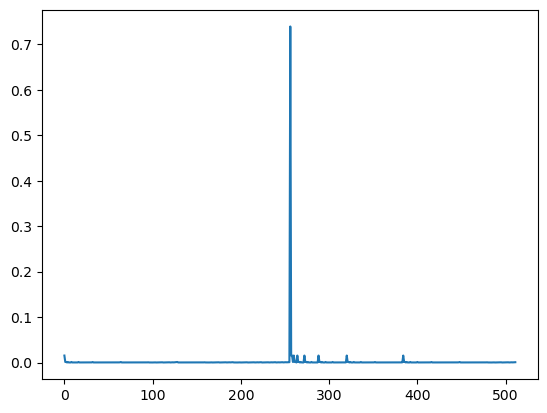

In [3]:
n=9
graph = nx.hypercube_graph(n)
gamma = gamma_hypercube(n) # Gamma do paper do renato https://arxiv.org/pdf/2212.08889.pdf

N = len(graph)
markedElements = [(N//2,-1)]

t = np.floor(np.pi/2 * sqrt(N))
# t = 43
initCond = list(range(0,len(graph)))


qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
qw.runWalk(time=t,initStateList=initCond)
print(max(qw.getProbVec()))
plt.plot(qw.getProbVec())


# Multiple walk search

In [4]:
def searchProbStepsPlotting2(qwak: QWAK, probDistList):
    """Plots the probability of finding the target as a function of the number of steps.

    Parameters
    ----------
    qwak : QWAK
        QWAK object containing the results of the simulation.
    """
    markedProbability = 0
    markedProbDistList = []
    markdElements = qwak.getMarkedElements()
    probDistList = probDistList
    if probDistList == []:
        raise EmptyProbDistList(
            "The probability distribution list is empty.")
    for probDist in probDistList:
        for element in markdElements:
            markedProbability += probDist.searchNodeProbability(
                element[0])
        markedProbDistList.append(markedProbability)
        markedProbability = 0
    return markedProbDistList

def multiple_hypercube_qwak(N,gammaList,timeList,markedElements,initCond):
    markedProbList = []
    markedElementsMatrix = []
    timeMatrix = []
    probDistList = []
    markedProbMatrix = []
    sampleCounter = 1
    for gamma in gammaList:
        qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
        print(f'GAMMA {round(gamma, 4)}/{max(gammaList)} \t Sample {sampleCounter}/{len(gammaList)}')
        sampleCounter += 1
        for time in timeList:
            qw.runWalk(time=time,initStateList=initCond)
            probDistList.append(copy.deepcopy(qw.getProbDist()))
        markedProbList = searchProbStepsPlotting2(qw,probDistList)
        markedProbMatrix.append(markedProbList)
        probDistList = []
        markedElementsMatrix.append(markedElements)
        timeMatrix.append( timeList)
    return markedProbMatrix,markedElementsMatrix,timeMatrix

In [5]:
n=9
graph = nx.hypercube_graph(n)
gamma = gamma_hypercube(n)
gammaMin = gamma/1.10

N = len(graph)
t =  (np.pi/(2) * np.sqrt(N))
maxTime = 2.2*t

print(f'N = {N}')
print(f'GammaMin = {gammaMin}')
print(f'T = {t}')

initCond = list(range(0,len(graph)))

samples = 200
timeList = np.linspace(0,maxTime,samples)
print(max(timeList))
gammaList =  np.linspace(gammaMin,gamma ,samples).tolist()
markedElements = [(N//2,-1)]

colors = plt.cm.rainbow(np.linspace(0, 1, len(gammaList)))
lines = ['-']*len(gammaList)
configVec = list(zip(colors,lines))

N = 512
GammaMin = 0.11725760675955989
T = 35.54306350526693
78.19473971158725


In [6]:
time_file = f'Datasets/HypercubeSearch/timeMatrix_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.txt'
markedElements_file = f'Datasets/HypercubeSearch/markedElementsMatrix_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.txt'
marked_prob_file = f'Datasets/HypercubeSearch/markedProbMatrix_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.txt'

if os.path.exists(time_file) and os.path.exists(markedElements_file) and os.path.exists(marked_prob_file):
    markedProbMatrix = load_nested_list_from_file(marked_prob_file)
    markedElementsMatrix = load_nested_list_from_file(markedElements_file)
    timeMatrix = load_nested_list_from_file(time_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    markedProbMatrix,markedElementsMatrix,timeMatrix = multiple_hypercube_qwak(N,gammaList,timeList,markedElements,initCond)
    if not os.path.exists(markedElements_file):
        write_nested_list_to_file(markedElements_file, markedProbMatrix)
    if not os.path.exists(time_file):
        write_nested_list_to_file(time_file, timeMatrix)
    if not os.path.exists(marked_prob_file):
        write_nested_list_to_file(marked_prob_file, markedProbMatrix)

File exists!


In [7]:
from matplotlib.colors import Normalize, ListedColormap

def plot_qwak(x_value_matrix, y_value_matrix, **kwargs):
    # Unpack optional parameters from kwargs with default values
    x_label = kwargs.get('x_label', None)
    y_label = kwargs.get('y_label', None)
    plot_title = kwargs.get('plot_title', None)
    legend_labels = kwargs.get('legend_labels', None)
    legend_title = kwargs.get('legend_title', None)
    legend_ncol = kwargs.get('legend_ncol', 3)
    legend_loc = kwargs.get('legend_loc', 'best')
    save_path = kwargs.get('save_path', None)
    font_size = kwargs.get('font_size', 12)
    figsize = kwargs.get('figsize', (10, 6))
    color_list = kwargs.get('color_list', None)
    line_style_list = kwargs.get('line_style_list', None)
    use_loglog = kwargs.get('use_loglog', False)
    use_cbar = kwargs.get('use_cbar', False)
    cbar_label = kwargs.get('cbar_label', None)
    cbar_ticks_generator = kwargs.get('cbar_ticks', None)
    cbar_num_ticks = kwargs.get('cbar_num_ticks', 3)
    cbar_tick_labels = kwargs.get('cbar_tick_labels', ['a', 'b', 'c'])
    x_num_ticks = kwargs.get('x_num_ticks', None)
    y_num_ticks = kwargs.get('y_num_ticks', None)
    x_round_val = kwargs.get('x_round_val', 3)
    y_round_val = kwargs.get('y_round_val', 3)
    v_line_values = kwargs.get('v_line_values', None)
    v_line_colors = kwargs.get('v_line_colors', None)
    v_line_style = kwargs.get('v_line_style', '--')
    x_lim = kwargs.get('x_lim', None)
    v_line_list_index = kwargs.get('v_line_list_index', None)
    use_grid = kwargs.get('use_grid', False)
    marker_list = kwargs.get('marker_list', None)
    cbar_ticks = kwargs.get('cbar_ticks', None)
    title_font_size = kwargs.get('title_font_size', None)
    xlabel_font_size = kwargs.get('xlabel_font_size', None)
    ylabel_font_size = kwargs.get('ylabel_font_size', None)
    legend_font_size = kwargs.get('legend_font_size', None)
    legend_title_font_size = kwargs.get('legend_title_font_size', None)
    tick_font_size = kwargs.get('tick_font_size', None)
    cbar_label_font_size = kwargs.get('cbar_label_font_size', None)
    use_grid = kwargs.get('use_grid', False)
    marker_list = kwargs.get('use_grid', None)
    
    
    if not isinstance(
            x_value_matrix[0],
            list) and not isinstance(
            x_value_matrix[0],
            np.ndarray):
        x_value_matrix = [x_value_matrix]
    if not isinstance(
            y_value_matrix[0],
            list) and not isinstance(
            y_value_matrix[0],
            np.ndarray):
        y_value_matrix = [y_value_matrix]

    if v_line_list_index is not None and v_line_values is None:
        raise ValueError(
            "v_line_list_index is provided, but v_line_values is None.")

    # plot the data for each row of the data matrix
    fig, ax = plt.subplots(figsize=figsize)
    if use_loglog:
        ax.loglog()
    if use_grid:
        ax.grid(True)

    axis_matrix_counter = 0
    color_matrix_counter = 0
    marker = None
    for xvalues, yvalues in zip(x_value_matrix, y_value_matrix):
        color = None
        line_style = None
        label = None
        if color_list is not None:
            color = color_list[axis_matrix_counter]
        if line_style_list is not None:
            line_style = line_style_list[axis_matrix_counter]
        if marker_list is not None:
            marker = marker_list[axis_matrix_counter] 
        if legend_labels is not None:
            label = legend_labels[axis_matrix_counter]
        ax.plot(xvalues, yvalues, label=label,
                color=color, linestyle=line_style, marker=marker)
        if v_line_values is not None and axis_matrix_counter == v_line_list_index:
            if v_line_colors is None:
                v_line_colors = ['k'] * len(v_line_values)
            ax.axvline(
                x=v_line_values[color_matrix_counter][0],
                ymin=0,
                ymax=v_line_values[color_matrix_counter][1] /
                ax.get_ylim()[1],
                color=v_line_colors[color_matrix_counter],
                linestyle=v_line_style,
                linewidth=1.5)
            color_matrix_counter += 1
        elif v_line_values is not None and v_line_list_index is None:
            ax.axvline(
                x=v_line_values[axis_matrix_counter][0],
                ymin=0,
                ymax=v_line_values[axis_matrix_counter][1] /
                ax.get_ylim()[1],
                color=color,
                linestyle=v_line_style,
                linewidth=1.5)
        axis_matrix_counter += 1
    if x_label is not None:
        ax.set_xlabel(x_label, fontsize=xlabel_font_size if xlabel_font_size else font_size + 2)
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize=ylabel_font_size if ylabel_font_size else font_size + 2)

    # set the plot title
    if plot_title is not None:
        ax.set_title(plot_title, fontsize=title_font_size if title_font_size else font_size + 4)

    # set the legend
    if legend_labels is not None:
        legend = ax.legend(
            loc=legend_loc,
            ncol=legend_ncol,
            fontsize=legend_font_size if legend_font_size else font_size - 1)
        if legend_title is not None:
            legend.set_title(legend_title, prop={'size': legend_title_font_size if legend_title_font_size else font_size - 1})

    # set font size for ticks
    ax.tick_params(axis='both', labelsize=tick_font_size if tick_font_size else font_size)

    # add colorbar
    if use_cbar:
        custom_cmap = ListedColormap(color_list)
        norm = Normalize(vmin=0, vmax=len(color_list) - 1)  # Adjust the normalization based on the number of colors
        cbar = plt.colorbar(
            plt.cm.ScalarMappable(
                norm=norm,
                cmap=custom_cmap),
            ax=ax,
        ticks=np.linspace(0, len(color_list) - 1, cbar_num_ticks))  # Set fewer ticks
        if cbar_label is not None:
            cbar.set_label(cbar_label, fontsize=cbar_label_font_size if cbar_label_font_size else font_size + 2)
        if cbar_tick_labels is not None:
            cbar.set_ticklabels(cbar_tick_labels)  # Set custom labels
        cbar.ax.tick_params(labelsize=tick_font_size if tick_font_size else font_size)


    if x_lim is not None:
        ax.set_xlim(x_lim)

    # save or show the plot
    if save_path is not None:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()


[(43.61616134666424, 0.7867983968794232)]
0.7867983968794232


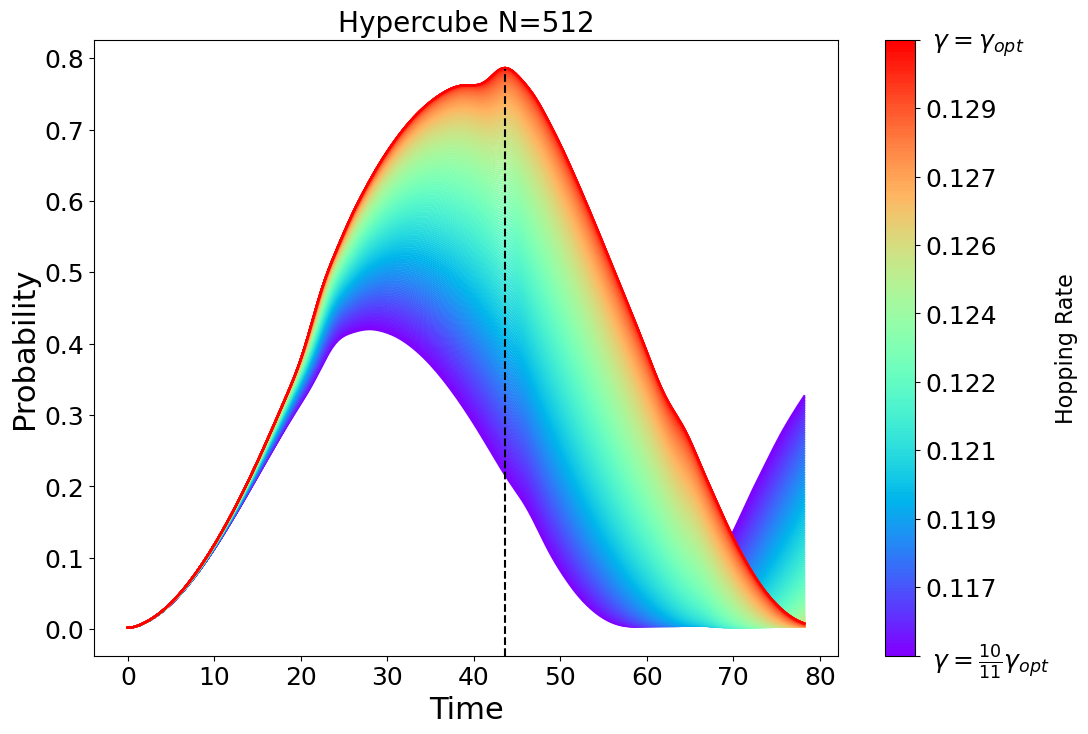

In [9]:
color_list = plt.cm.rainbow(np.linspace(0, 1, len(gammaList)))

v_line_values = [(timeMatrix[-1][np.argmax(markedElementsMatrix[-1])],np.max(markedElementsMatrix[-1]))]
print(v_line_values)

cbar_num_ticks = 10
params = {
    'font_size' : 14,
    'figsize': (12, 8),
    'plot_title' : f'Hypercube N={N}',
    'x_label' : 'Time',
    'y_label' : 'Probability',
    'legend_labels' : None,
    'legend_loc': None,
    'legend_title' : 'Solutions',
    'legend_ncol' : 1,
    # 'color_list' : ['#0000FF', '#008000', '#525252'],
    'color_list' : color_list,
    # 'line_style_list' : ['--', '-','-.' ],
    'save_path' : f'Output/HypercubeSearch/hypercubePlot_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.png',
    'use_loglog': False,
    'use_cbar' : True,
    'cbar_label' : 'Hopping Rate', 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'cbar_ticks_generator': gammaList,
    'cbar_tick_labels': [r' $\gamma = \frac{10}{11}\gamma_{opt}$']  + [f'{round(x,3)}' for x in np.linspace(gammaMin,gamma ,cbar_num_ticks-2).tolist()] + [r' $\gamma = \gamma_{opt}$'],
    'cbar_num_ticks' : cbar_num_ticks,
    'x_lim' : None,
    'x_num_ticks' : 7,
    'y_num_ticks' : 7,
    'x_round_val' : 1,
    'y_round_val' : 3,
    'v_line_values' : v_line_values,
    'v_line_style': '--',
    'v_line_list_index' : len(gammaList)-1,
    'title_font_size': 20,
    'xlabel_font_size': 22,
    'ylabel_font_size': 22,
    'legend_font_size': 14,
    'legend_title_font_size': 14,
    'tick_font_size': 18,
    
}
print(v_line_values[0][1])

plot_qwak(x_value_matrix = timeMatrix, y_value_matrix = markedElementsMatrix,**params)